### A) summarize the main results in the paper;

### B) Reproduce the results in Figure 1 in paper

### C) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). 

In [105]:
import numpy as np
import random
import numpy
from matplotlib import pyplot
import matplotlib.pyplot as plt


np.random.seed(1)

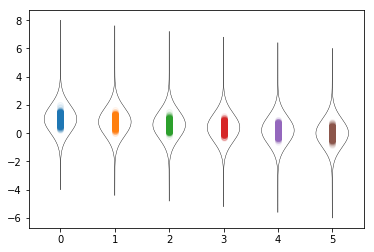

In [3]:
#mu = 0.0
sigma = 1/4
#num_bandits = 10
num_samples = 1_000
bandit_means = [ 1, 4/5, 3/5, 2/5, 1/5, 0]
#bandit_means = np.random.normal(mu, sigma, num_bandits)
rewards = [(idx, np.random.normal(bandit_mean, sigma, num_samples)) for idx,bandit_mean in enumerate(bandit_means)]



def plot_vertical_gaussian(support, sd=1.0, height=0.3, xpos=0.0, ypos=0.0, ax=None, **kwargs):       
    gaussian = np.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    ax.plot((gaussian * height) + xpos, support + ypos, **kwargs)
    ax.plot( -(gaussian * height) + xpos, support + ypos, **kwargs)

support = np.linspace(-2, 2, 1000)
fig, ax = plt.subplots()


for (action, distribution) in rewards:
    xs = np.zeros(num_samples) + action
    ys = distribution
    plt.scatter(xs, ys, alpha=0.05)

for idx, mu in enumerate(bandit_means):
    sigma = 6.0
    support = np.linspace(mu - sigma, mu + sigma, 1_000)
    plot_vertical_gaussian(support, sd=1., xpos=idx, ypos=mu, ax=ax, linewidth=0.4, color='k')


plt.show()

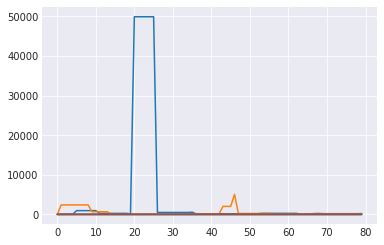

In [166]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


class NormalBandit:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def reward(self):
        return np.random.normal(self.mu, self.sigma, 1)[0]        
        
class ActionElminiationBanditTrial:
    def __init__(self, bandits, r_k=1):
        """
        bandit_means
            a list of means that will be used to build the bandits
        r_k 
            is the number of samples per epoch for each arm
        """
        self.bandits = bandits 
        
        self.bandit_count = len(self.bandits)
        self.k = self.bandit_count
        
        self.optimal_bandit = np.argmax(bandit_means)
        self.rewards_per_arm = [[] for _x in np.arange(0, self.bandit_count)]
        self.estimated_action_reward = np.zeros(self.bandit_count)

        self.delta = 0.1       
        self.active_bandits = np.ones(self.bandit_count)

        #self.confidence_bounds_per_arm = [initial_del for _x in np.arange(0,self.bandit_count)]
        self.r_k = r_k
        self.H1s = []
    
    def empirical_mean(self, bandit_index):
        r"""
        Calculate the empirical mean of a given bandit (indexed). When an arm is hasn't been pulled, return -Infinity
        """
        if len(self.rewards_per_arm[bandit_index]) == 0:
            return -np.Inf
        return np.mean(self.rewards_per_arm[bandit_index])
    
    def active_bandit_indexes(self):
        r"""
        self.active_bandits is |n|. Return only the indexes == 1.
        """
        return np.nonzero(self.active_bandits)[0]
    
    def estimated_best_bandit_mean(self):
        """ returns a tuple with the best bandit index and the empirical mean"""
        all_empirical_means = [self.empirical_mean(idx) for idx,rewards in enumerate(self.bandits)]
        best_arm_index = np.nanargmax(all_empirical_means)
        return (best_arm_index, all_empirical_means[best_arm_index])
        
    def pick_arm(self, idx):
        return self.bandits[idx]
    
    def drop_arm(self, idx):
        self.active_bandits[idx] = 0
        
    def C_ik(self, bandit_index):
        k = len(self.rewards_per_arm[bandit_index])
        delta = self.delta
        n = self.bandit_count        
        if k == 0:
            return 0

        A = np.power(np.pi , 2 ) / 3
        B = n * np.power(k, 2) / delta   
        
        return np.sqrt( np.log( A * B) / k  )
    
    def stopping_condition_reached(self):
        return len(self.active_bandit_indexes()) == 1
    
    def delta_from_best_arm(self, bandit_index):
        r""" 
        this is the ground truth best arm:
        \delta_i = \mu_{i_*} - \mu_i"""
        return self.pick_arm(self.optimal_bandit).mu - self.empirical_mean(bandit_index)
    
    def H1(self):
        deltas = []
        for idx, bandit in enumerate(self.bandits):
            mean = self.delta_from_best_arm(idx)
            if mean == np.inf:
                mean = 1/6
            else:
                result = mean
            deltas.append(result)
        
#        print(deltas)
        indexes = [idx for idx, bandit in enumerate(self.bandits) ]#  if idx != self.optimal_bandit]
#        print("indexes: {}".format(indexes))
        deltas = [np.power(self.delta_from_best_arm(idx), -2) for idx in indexes]
        return deltas
#        print("H1: {}".format(np.sum(deltas)))
    
    def run_trial(self, time_steps=80):
        
        current_epoch = 0
        for step in np.arange(0,time_steps):
            # Stopping Condition
            if self.stopping_condition_reached():
                mean = self.estimated_best_bandit_mean()
                print("Stopping. Best Arm: {}. Found in {} time steps".format(mean[0], step))
                print("Estimated mean: {}. ".format(mean[1]))
                print("Empirical mean: {}. ".format(self.bandits[self.optimal_bandit].mu))
                break
            
            # TODO: not sure if we should randomly pick after the first epoch??
            if current_epoch > 0:
                bandit_index = np.random.choice(self.active_bandit_indexes())
            else:
                bandit_index = step % (self.k - 1)

            bandit = self.pick_arm(bandit_index)
            self.rewards_per_arm[bandit_index].append(bandit.reward())
            
            reference_arm = self.estimated_best_bandit_mean()
            reference_C_t = self.C_ik(reference_arm[0])
#            print(reference_arm, reference_C_t)
            
            for bandit_idx in self.active_bandit_indexes():
                candidate_arm_mean = self.empirical_mean(bandit_idx)
                candidate_C_t = self.C_ik(bandit_idx)
                lhs = reference_arm[1] - reference_C_t
                rhs = candidate_arm_mean + candidate_C_t
                if lhs >= rhs and rhs > (-np.inf):
                    print("Dropping:  {}: {} < {}".format(bandit_idx, lhs, rhs ))
                    self.drop_arm(bandit_idx)
            
            
#            print("{} - {} \t\t\t ({})".format(bandit_index, reward, step))
#            print("C.{}: {}".format(bandit_index, self.C_ik(bandit_index)))
            h1 = self.H1()
            self.H1s.append(h1)
            #print("h1: {}".format(h1))
            if step > 0 and step % (self.k - 1) == 0:
                current_epoch += 1

#                print("epch - {}".format(current_epoch))
    
    def pull_arm(idx):
        return self.bandits[idx].reward()

    
bandit_means = [ 1, 4/5, 3/5, 2/5, 1/5, 0]
bandits = [NormalBandit(mean, 1/4) for mean in bandit_means]
trial = ActionElminiationBanditTrial(bandits)
trial.run_trial()


#trial.H1s
plt.style.use('seaborn-darkgrid')

plt.plot(np.arange(0, len(trial.H1s)), [ts[0] for ts in trial.H1s] )
plt.plot(np.arange(0, len(trial.H1s)), [ts[1] for ts in trial.H1s] )
plt.plot(np.arange(0, len(trial.H1s)), [ts[2] for ts in trial.H1s] )
plt.plot(np.arange(0, len(trial.H1s)), [ts[3] for ts in trial.H1s] )
plt.plot(np.arange(0, len(trial.H1s)), [ts[4] for ts in trial.H1s] )
plt.plot(np.arange(0, len(trial.H1s)), [ts[5] for ts in trial.H1s] )
plt.show()

In [138]:
len(trial.H1s)

100

### D) discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identification